In [4]:
import math
import numpy as np
import os 
import pandas as pd
from sklearn import metrics
import matplotlib.pyplot as plt

import torch
import torch.nn as nn 
import torch.nn.functional as F
import torch.optim as optim 
from torch.utils.data import Dataset, DataLoader 
from torchsummary import summary

ModuleNotFoundError: No module named 'torchsummary'

In [3]:
data_csv = './data/data_9_3_2023.csv'
df_full = pd.read_csv(data_csv)

In [4]:
df_full.head()

,video_count,frame_count,eye,mouth,area_eye,area_mouth,pupil,label
0,0,0,0.073999,0.271307,184.354345,881.008199,0.462096,1
1,0,1,0.084626,0.311049,188.483534,851.794056,0.463978,1
2,0,2,0.081439,0.288891,200.811384,800.032050,0.473497,1
3,0,3,0.083046,0.293956,200.400366,830.599106,0.473526,1
4,0,4,0.075235,0.312621,197.084739,866.972921,0.466438,1


In [5]:
df_full.columns

Index(['video_count', 'frame_count', 'eye', 'mouth', 'area_eye', 'area_mouth',
       'pupil', 'label'],
      dtype='object')

In [6]:
time_steps=5
# arr = np.array(df_full).reshape(-1, time_steps, 8)
# np.random.shuffle(arr)
# arr = arr.reshape(-1, 8)

# df_full = pd.DataFrame(arr, columns = df_full.columns)

# df_full

In [7]:
import random

all_videos = df_full["video_count"].max()
to_train = math.ceil(all_videos*0.8)
to_test = all_videos - to_train
to_validate = math.ceil(to_test*0.3)
videos = list(range(all_videos))
random.shuffle(videos)

print(videos)

to_train_videos = videos[:to_train]
to_test_videos = videos[to_train:to_validate+to_train]
to_validate_videos = videos[to_validate+to_train:]

if len(to_test_videos) < len(to_validate_videos):
    temp = to_validate_videos
    to_validate_videos = to_test_videos
    to_test_videos = temp

print(to_train_videos)
print(to_test_videos)
print(to_validate_videos)

[0, 14, 22, 24, 20, 11, 21, 10, 26, 3, 15, 25, 19, 5, 12, 23, 18, 6, 7, 17, 13, 8, 2, 4, 16, 1, 9]
[0, 14, 22, 24, 20, 11, 21, 10, 26, 3, 15, 25, 19, 5, 12, 23, 18, 6, 7, 17, 13, 8]
[16, 1, 9]
[2, 4]


In [16]:
test_df_full = df_full.apply(lambda row: row[df_full['video_count'].isin(to_test_videos)])
test_df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 220 to 3739
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   video_count  660 non-null    int64  
 1   frame_count  660 non-null    int64  
 2   eye          660 non-null    float64
 3   mouth        660 non-null    float64
 4   area_eye     660 non-null    float64
 5   area_mouth   660 non-null    float64
 6   pupil        660 non-null    float64
 7   label        660 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 46.4 KB


In [17]:
train_df_full = df_full.apply(lambda row: row[df_full['video_count'].isin(to_train_videos)])
train_df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4840 entries, 0 to 5939
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   video_count  4840 non-null   int64  
 1   frame_count  4840 non-null   int64  
 2   eye          4840 non-null   float64
 3   mouth        4840 non-null   float64
 4   area_eye     4840 non-null   float64
 5   area_mouth   4840 non-null   float64
 6   pupil        4840 non-null   float64
 7   label        4840 non-null   int64  
dtypes: float64(5), int64(3)
memory usage: 340.3 KB


In [18]:
val_df_full = df_full.apply(lambda row: row[df_full['video_count'].isin(to_validate_videos)])
val_df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 440 to 1099
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   video_count  440 non-null    int64  
 1   frame_count  440 non-null    int64  
 2   eye          440 non-null    float64
 3   mouth        440 non-null    float64
 4   area_eye     440 non-null    float64
 5   area_mouth   440 non-null    float64
 6   pupil        440 non-null    float64
 7   label        440 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 30.9 KB


In [19]:
test_df = test_df_full.drop(['video_count', 'frame_count'], axis=1)
test_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 660 entries, 220 to 3739
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   eye         660 non-null    float64
 1   mouth       660 non-null    float64
 2   area_eye    660 non-null    float64
 3   area_mouth  660 non-null    float64
 4   pupil       660 non-null    float64
 5   label       660 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 36.1 KB


In [20]:
train_df = train_df_full.drop(['video_count','frame_count'], axis=1)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4840 entries, 0 to 5939
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   eye         4840 non-null   float64
 1   mouth       4840 non-null   float64
 2   area_eye    4840 non-null   float64
 3   area_mouth  4840 non-null   float64
 4   pupil       4840 non-null   float64
 5   label       4840 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 264.7 KB


In [21]:
val_df = val_df_full.drop(['video_count', 'frame_count'], axis=1)
val_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 440 entries, 440 to 1099
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   eye         440 non-null    float64
 1   mouth       440 non-null    float64
 2   area_eye    440 non-null    float64
 3   area_mouth  440 non-null    float64
 4   pupil       440 non-null    float64
 5   label       440 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 24.1 KB


In [22]:
class FFEDataset(Dataset):
  def __init__ (self, data, labels, time_steps=5, n_features=4):
    super(FFEDataset, self).__init__()
    self.time_steps = time_steps
    self.n_features = n_features
    
    # arr = np.array(data).reshape(-1, time_steps, self.n_features)
    # Y = arr[:, :, -1]
    # Y = Y[:, 0:1]
    
    self.data = np.array(data).reshape(-1, self.time_steps, self.n_features)
    self.labels = labels
    
  
  def __len__(self):
    return len(self.labels)

  def __getitem__(self, index):
    return torch.FloatTensor(self.data[index]), torch.FloatTensor(self.labels[index])

In [14]:
# df = df_full.drop(['video_count','frame_count', 'label'], axis=1)
# label = df_full['label']


# df_test = df_full.drop(['video_count','frame_count'], axis=1)
# arr = np.array(df_test).reshape(-1, time_steps, 6)
# Y = arr[:, :, -1]
# Y = Y[:, 0:1]

# dataset = FFEDataset(df,Y, time_steps=time_steps, n_features=5)


# train_size = int(0.8 * len(dataset))

# print(len(dataset))
# train_size = 1032

# test_size = len(dataset) - train_size

# test_size  = 200

# train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])

# val_size = int(test_size * 0.5)
# test_size = test_size - val_size

# test_dataset, val_dataset = torch.utils.data.random_split(test_dataset, [test_size, val_size])

In [23]:
X = train_df.drop(['label'], axis=1)
arr = np.array(train_df).reshape(-1, time_steps, 6)
Y = arr[:, :, -1]
Y = Y[:, 0:1]

train_dataset = FFEDataset(X,Y, time_steps=time_steps, n_features=5)

In [24]:
X = test_df.drop(['label'], axis=1)
arr = np.array(test_df).reshape(-1, time_steps, 6)
Y = arr[:, :, -1]
Y = Y[:, 0:1]

test_dataset = FFEDataset(X,Y, time_steps=time_steps, n_features=5)

In [25]:
X = val_df.drop(['label'], axis=1)
arr = np.array(val_df).reshape(-1, time_steps, 6)
Y = arr[:, :, -1]
Y = Y[:, 0:1]

val_dataset = FFEDataset(X,Y, time_steps=time_steps, n_features=5)

In [26]:
len(test_dataset)

132

In [27]:
len(train_dataset)

968

In [28]:
len(val_dataset)

88

In [29]:
batch_size = 4

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False)

In [30]:
class CLF_LSTM(nn.Module):
  def __init__(self, batch_size):
    super(CLF_LSTM, self).__init__()
    self.x_dim = 5
    self.time_steps = 5
    self.input_dim = 64
    self.hidden_dim = 64
    self.num_layers = 2
    self.batch_size = batch_size
    self.pre_fc = nn.Linear(self.time_steps * self.x_dim, self.time_steps * self.input_dim)
    self.lstm = nn.LSTM(self.input_dim, self.hidden_dim, self.num_layers, batch_first=True)
    self.d1 = nn.Dropout(p=0.5)
    self.fc1 = nn.Linear(self.hidden_dim, 256)
    self.d2 = nn.Dropout(p=0.5)
    self.fc2 = nn.Linear(256, 64)
    self.fc3 = nn.Linear(64, 8)
    self.fc4 = nn.Linear(8, 1)
    
  def init_hidden(self):
    self.hidden = (torch.zeros((self.num_layers, self.batch_size, self.hidden_dim)), \
    torch.zeros((self.num_layers, self.batch_size, self.hidden_dim)))
  
  def forward(self, x):
    self.init_hidden()
    out = x.reshape(-1, self.time_steps * self.x_dim)
    out = F.relu(self.pre_fc(out))
    out = out.reshape(-1, self.time_steps, self.input_dim)
    out, self.hidden = self.lstm(out, self.hidden)
    out = out[:, -1, :]
    out = self.d1(out)
    out = F.relu(self.fc1(out))
    out = self.d2(out)
    out = F.relu(self.fc2(out))
    out = F.relu(self.fc3(out))
    out = self.fc4(out)
    return out

In [31]:
model = CLF_LSTM(batch_size)

In [32]:
model

CLF_LSTM(
  (pre_fc): Linear(in_features=25, out_features=320, bias=True)
  (lstm): LSTM(64, 64, num_layers=2, batch_first=True)
  (d1): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=64, out_features=256, bias=True)
  (d2): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=256, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=8, bias=True)
  (fc4): Linear(in_features=8, out_features=1, bias=True)
)

In [36]:
for param in model.parameters():
  param.requires_grad = True

lr = 0.001
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
opt = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([2]))

In [25]:
def train_model(epochs, opt, model, model_path):
  train_loss = []
  val_loss = []
  min_loss = np.Inf
  max_acc = 0

  for e in range(epochs):
    running_loss = 0.0
    model.train()
    model.to(device)
    for batch_data, batch_label in iter(train_loader):
      batch_data = batch_data.to(device)
      batch_label = batch_label.to(device)
      
      opt.zero_grad()

      batch_pred = model(batch_data)

      loss = criterion(batch_pred, batch_label)
      loss.backward()
      opt.step()
      running_loss += loss.item()
    train_loss.append(running_loss / len(train_dataset))

    model.eval()

    val_labels = np.zeros((len(val_dataset), 1))
    val_preds = np.zeros((len(val_dataset), 1))
    indx = 0
    running_loss = 0.0
    for batch_data, batch_label in iter(val_loader):
      batch_data = batch_data.to(device)
      batch_label = batch_label.to(device)
      with torch.no_grad():
        batch_pred = model(batch_data)
        loss = criterion(batch_pred, batch_label)
        running_loss += loss.item()
      batch_pred = torch.sigmoid(batch_pred).gt(0.5).int()
      val_preds[ indx : (indx + batch_pred.shape[0]), :] = batch_pred.to("cpu").data.numpy()
      val_labels[ indx : (indx + batch_label.shape[0]), :] = batch_label.to("cpu").data.numpy()
      indx = indx + batch_pred.shape[0]
    val_loss.append(running_loss / len(val_dataset))
    val_acc = metrics.accuracy_score(val_labels, val_preds)

    if val_loss[-1] < min_loss:
      min_loss = val_loss[-1]
      model.to("cpu")
      torch.save(model.state_dict(), model_path)
      print ('saved model at epoch = %d for Min val loss' %(e))


    if e % 2 == 0:
      print ('epoch=%d training_loss=%.4f val_loss=%.4f  val_acc = %.4f' %(e, train_loss[-1], val_loss[-1], val_acc))
    
  plt.plot(range(len(train_loss)), train_loss)
  plt.plot(range(len(val_loss)), val_loss)
  plt.legend(["Train Loss", "Val Loss"], loc="upper right")



saved model at epoch = 0 for Min val loss
epoch=0 training_loss=0.2525 val_loss=0.2883  val_acc = 1.0000
saved model at epoch = 1 for Min val loss
saved model at epoch = 2 for Min val loss
epoch=2 training_loss=0.2408 val_loss=0.2375  val_acc = 1.0000
saved model at epoch = 4 for Min val loss
epoch=4 training_loss=0.2407 val_loss=0.2331  val_acc = 1.0000
epoch=6 training_loss=0.2406 val_loss=0.2331  val_acc = 1.0000
saved model at epoch = 7 for Min val loss
saved model at epoch = 8 for Min val loss
epoch=8 training_loss=0.2406 val_loss=0.2325  val_acc = 1.0000
epoch=10 training_loss=0.2406 val_loss=0.2394  val_acc = 1.0000
epoch=12 training_loss=0.2405 val_loss=0.2342  val_acc = 1.0000
saved model at epoch = 13 for Min val loss
epoch=14 training_loss=0.2405 val_loss=0.2336  val_acc = 1.0000
epoch=16 training_loss=0.2406 val_loss=0.2354  val_acc = 1.0000
epoch=18 training_loss=0.2408 val_loss=0.2330  val_acc = 1.0000
epoch=20 training_loss=0.2404 val_loss=0.2334  val_acc = 1.0000
saved 

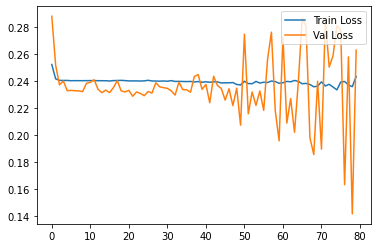

In [26]:
train_model(80, opt, model, './models/clf_lstm.pth')

In [34]:
def val_model(model):
  test_preds = np.zeros((len(val_dataset), 1))
  test_labels = np.zeros((len(val_dataset), 1))
  print(len(val_dataset))
    
  model.to(device)
  model.eval()
  indx = 0
  with torch.no_grad():
    for batch_data, batch_labels in iter(val_loader):
      batch_data = batch_data.to(device)
      batch_labels = batch_labels.to(device)
      batch_pred = torch.sigmoid(model(batch_data)).gt(0.5).int()
      test_preds[ indx : (indx + batch_pred.shape[0]), :] = batch_pred.to("cpu").data.numpy()
      test_labels[ indx : (indx + batch_labels.shape[0]), :] = batch_labels.to("cpu").data.numpy()
      indx = indx + batch_pred.shape[0]
  
  accuracy = metrics.accuracy_score(test_labels, test_preds)
  print ('accuracy', accuracy)
  # print(test_preds)
  # print(test_labels)

  return accuracy, test_preds, test_labels

In [39]:
model = CLF_LSTM(batch_size=batch_size)
model.load_state_dict(torch.load('./models/clf_lstm.pth'))
accuracy, val_pred, val_lab = val_model(model)
print (metrics.confusion_matrix(val_lab, val_pred))

88
accuracy 1.0
[[88]]


In [40]:
def test_model(model):
  test_preds = np.zeros((len(test_dataset), 1))
  test_labels = np.zeros((len(test_dataset), 1))
  print(len(test_dataset))
  model.to(device)
  model.eval()
  indx = 0
  with torch.no_grad():
    for batch_data, batch_labels in test_loader:
      batch_data = batch_data.to(device)
      batch_labels = batch_labels.to(device)
      batch_pred = torch.sigmoid(model(batch_data)).gt(0.5).int()
      test_preds[ indx : (indx + batch_pred.shape[0]), :] = batch_pred.to("cpu").data.numpy()
      test_labels[ indx : (indx + batch_labels.shape[0]), :] = batch_labels.to("cpu").data.numpy()
      indx = indx + batch_pred.shape[0]
  
  accuracy = metrics.accuracy_score(test_labels, test_preds)
  print ('accuracy', accuracy)
  return accuracy, test_preds, test_labels

model = CLF_LSTM(batch_size=1)
model.load_state_dict(torch.load('./models/clf_lstm.pth'))
accuracy, test_pred, test_lab = test_model(model)
metrics.confusion_matrix(test_lab, test_pred)

132
accuracy 0.6666666666666666


array([[ 0, 44],
       [ 0, 88]])